## Домашнее задание 3 "Бинарный классификатор на основе CNN"

ФИО: Фадеев Роман Андреевич

### Импорт основных библиотек

In [24]:
import numpy as np
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt

### Распаковка архива "indoor_outdoor_dataset.zip" с датасетом

In [25]:
import zipfile

zip_file = 'indoor_outdoor_dataset.zip'
output_dir = './big-data'
try:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
except:
    print("Cant find zip file, skipping")


Cant find zip file, skipping


### Подготовка тренировочной, валидационной и тестовой выборок

In [26]:
TRAIN_FROM_CHECKPOINT = False

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=output_dir, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

Данные разделяю по 256 батчей (~ 3.5 GB VRAM) для более быстрой обработки

In [27]:
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
batch_size = 256 # Уменьшить при переполнении памяти

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [28]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # rgb
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)

        return x

In [29]:
model = CNNModel()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
def save_checkpoint(state, filename='checkpoint.pth'):
    """Сохранение состояния модели"""

    torch.save(state, filename)

def load_checkpoint(filename='checkpoint.pth'):
    
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict']) 
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  
    epoch = checkpoint['epoch'] 
    loss = checkpoint['loss'] 
    accuracy = checkpoint['accuracy']  
    print(f"Checkpoint loaded. Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}")
    return epoch, loss, accuracy

In [31]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/exp_1')

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, plot=True):
    try:
        best_val_acc = 0.0

        train_loss_epochs = []
        val_loss_epochs = []
        train_accuracy_epochs = []
        val_accuracy_epochs = []
        
        for epoch in tqdm(range(num_epochs)):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

                optimizer.zero_grad()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
            
            train_loss = running_loss / len(train_loader)
            train_acc = correct / total
            
            val_loss, val_acc = evaluate_model(model, val_loader, criterion)

            train_loss_epochs.append(train_loss)
            train_accuracy_epochs.append(train_acc)

            val_loss_epochs.append(val_loss)
            val_accuracy_epochs.append(val_acc)
            
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}, '
                f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
            
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(val_loss_epochs, label='Val')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(val_accuracy_epochs, label='Val accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
            
            writer.add_scalar('Loss/train', train_loss, epoch)
            writer.add_scalar('Accuracy/train', train_acc, epoch)
            writer.add_scalar('Loss/val', val_loss, epoch)
            writer.add_scalar('Accuracy/val', val_acc, epoch)
            

            if val_acc > best_val_acc:
                print(f'Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving model...')
                best_val_acc = val_acc
                
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': val_loss,
                    'accuracy': val_acc
                }
                save_checkpoint(checkpoint, 'cnn_best_checkpoint.pth')
    except KeyboardInterrupt:
        print("Interrupted")

        pass
            
    
def evaluate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    loss = running_loss / len(loader)
    accuracy = correct / total
    return loss, accuracy

  0%|                                                                          | 0/15 [00:00<?, ?it/s]

Epoch [1/15], Loss: 0.3314, Accuracy: 0.8551, Val Loss: 0.2960, Val Accuracy: 0.8923


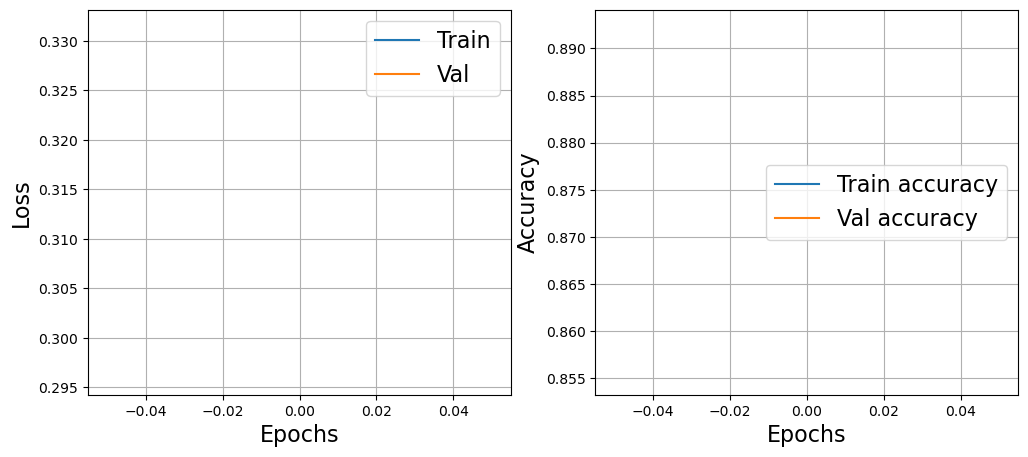

Validation accuracy improved from 0.0000 to 0.8923. Saving model...


  7%|████▏                                                         | 1/15 [21:38<5:02:53, 1298.12s/it]

Epoch [2/15], Loss: 0.2553, Accuracy: 0.8943, Val Loss: 0.2488, Val Accuracy: 0.9043


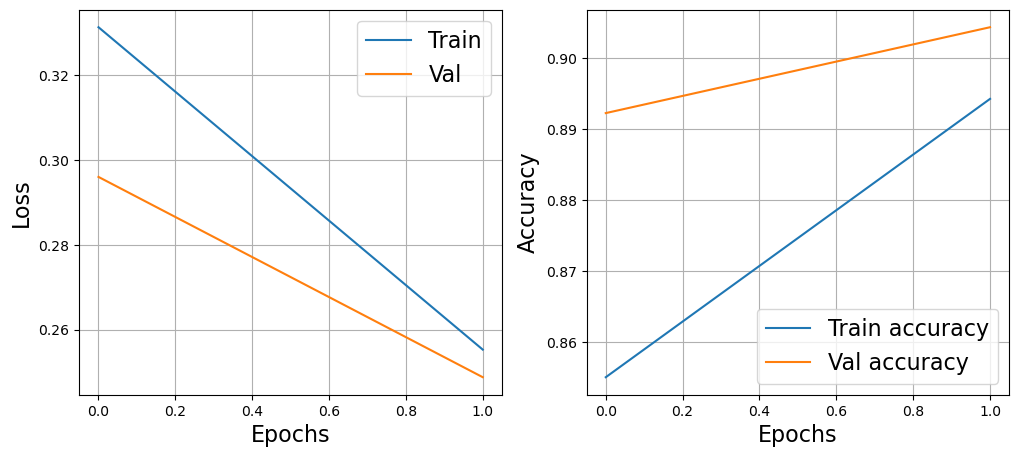

 13%|████████▎                                                     | 2/15 [52:12<5:49:38, 1613.76s/it]

Validation accuracy improved from 0.8923 to 0.9043. Saving model...
Epoch [3/15], Loss: 0.2298, Accuracy: 0.9062, Val Loss: 0.2391, Val Accuracy: 0.8964


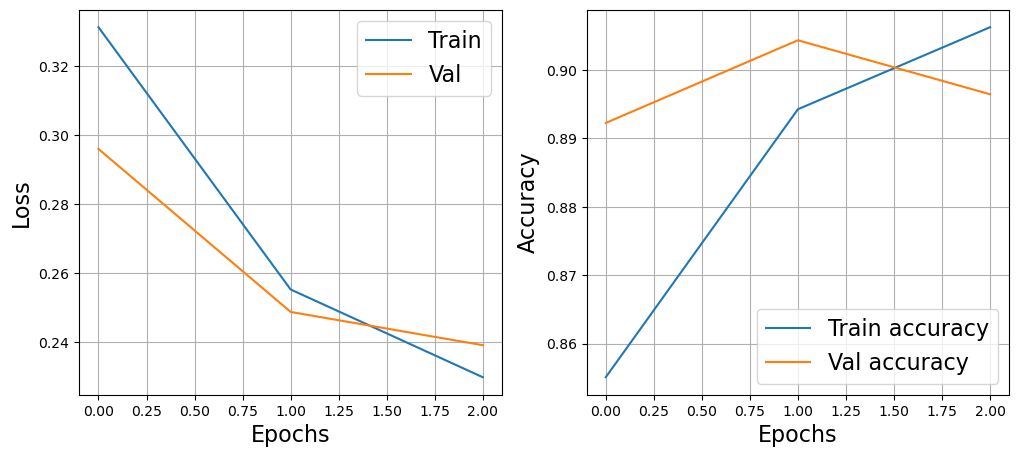

 20%|████████████                                                | 3/15 [1:18:48<5:21:07, 1605.64s/it]

Epoch [4/15], Loss: 0.2071, Accuracy: 0.9166, Val Loss: 0.2220, Val Accuracy: 0.9128


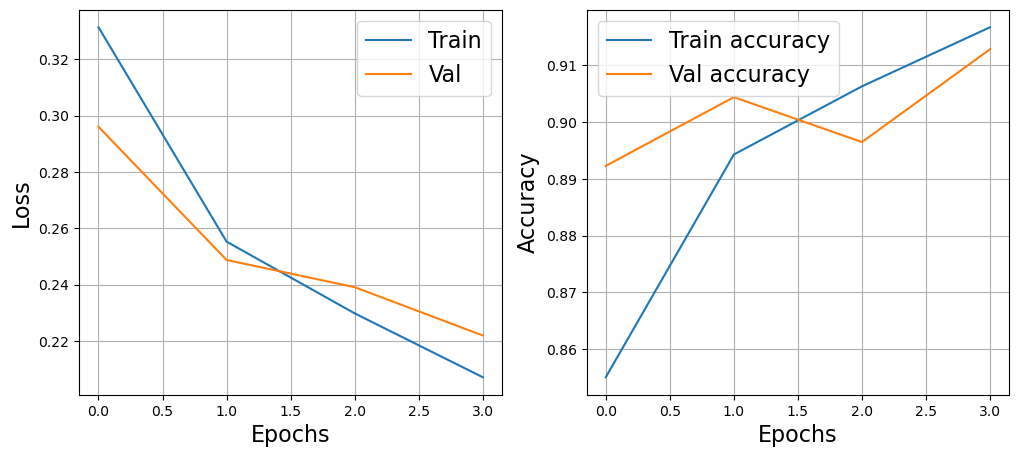

Validation accuracy improved from 0.9043 to 0.9128. Saving model...


 27%|████████████████                                            | 4/15 [1:43:23<4:44:52, 1553.90s/it]

Epoch [5/15], Loss: 0.1828, Accuracy: 0.9268, Val Loss: 0.2218, Val Accuracy: 0.9120


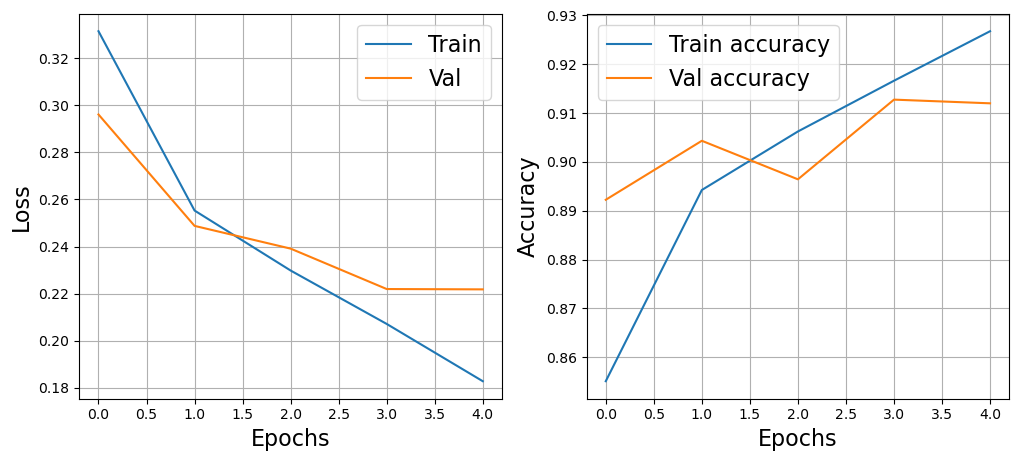

 33%|████████████████████                                        | 5/15 [2:10:24<4:22:59, 1577.99s/it]

Epoch [6/15], Loss: 0.1528, Accuracy: 0.9394, Val Loss: 0.2423, Val Accuracy: 0.9114


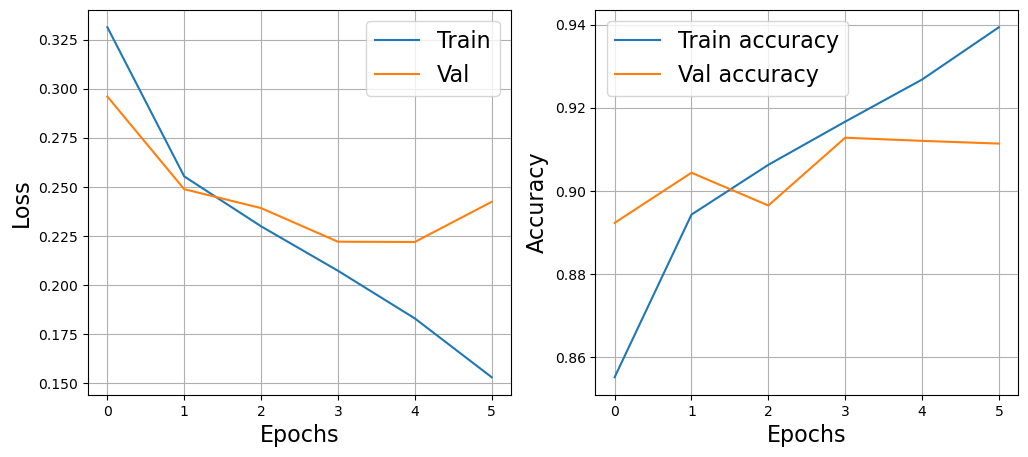

 40%|████████████████████████                                    | 6/15 [2:39:47<4:06:09, 1641.08s/it]

Epoch [7/15], Loss: 0.1181, Accuracy: 0.9536, Val Loss: 0.2670, Val Accuracy: 0.9114


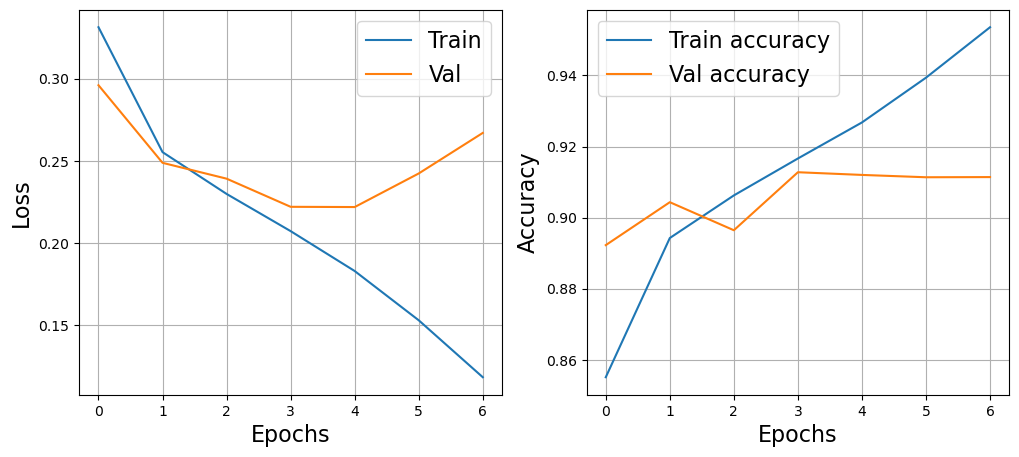

 47%|████████████████████████████                                | 7/15 [3:06:58<3:33:41, 1602.63s/it]

Interrupted


In [32]:
if not TRAIN_FROM_CHECKPOINT:
    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

In [33]:
if TRAIN_FROM_CHECKPOINT:    
    model = CNNModel().to(device)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

    train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=10,
    )

### Загрузка лучшего чекпоинта

In [40]:
model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epoch, loss, accuracy = load_checkpoint('cnn_best_checkpoint.pth')

model.eval()

Checkpoint loaded. Epoch: 4, Loss: 0.22195494026871201, Accuracy: 0.912769170807756


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=32768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
  )
)

### Определение ошибочно предсказанных изображений, метрик.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


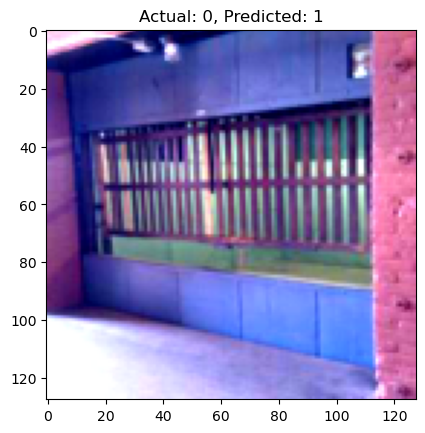

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


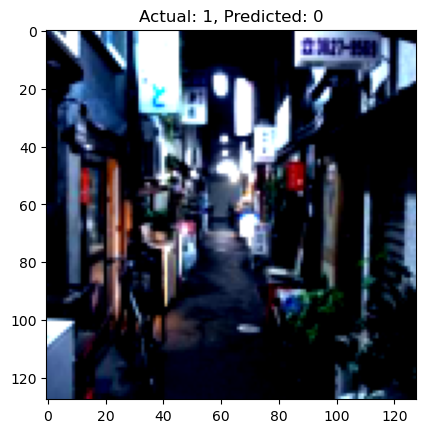

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


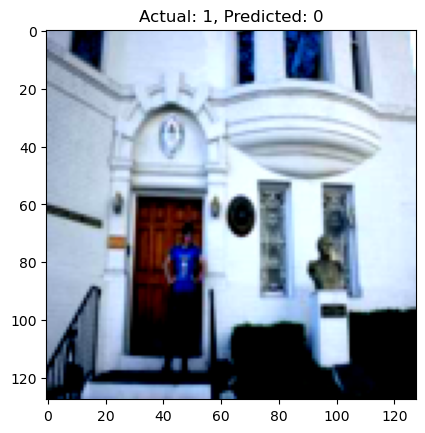

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


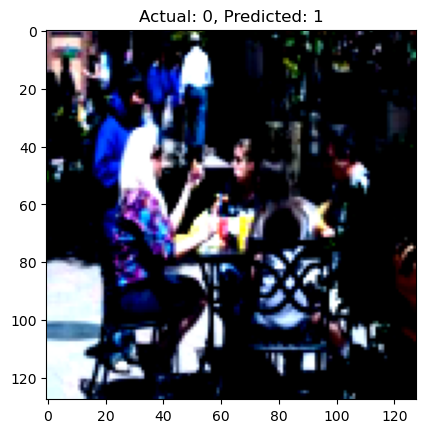

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


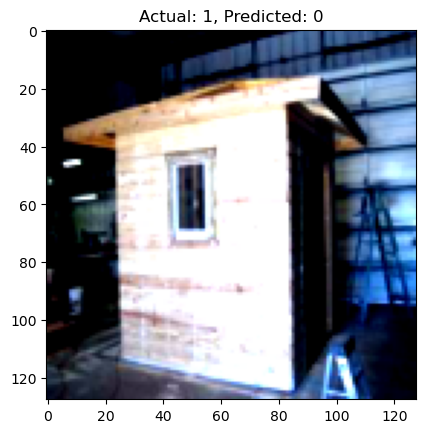

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


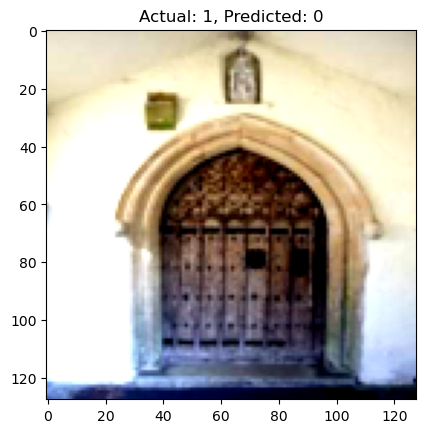

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


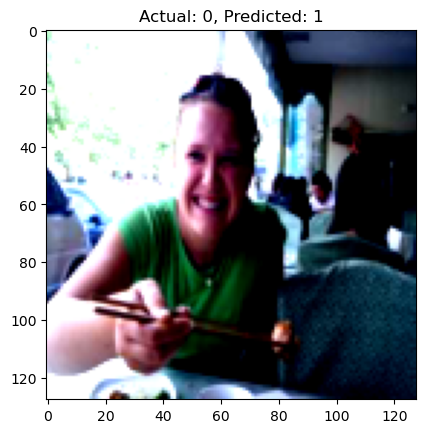

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


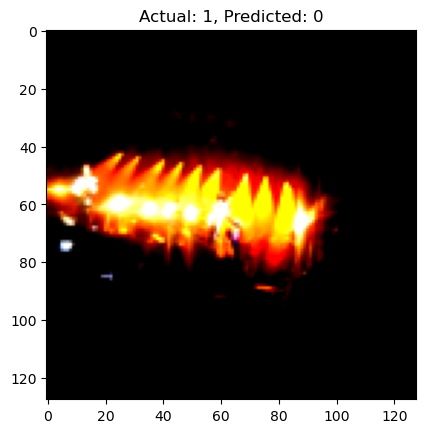

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


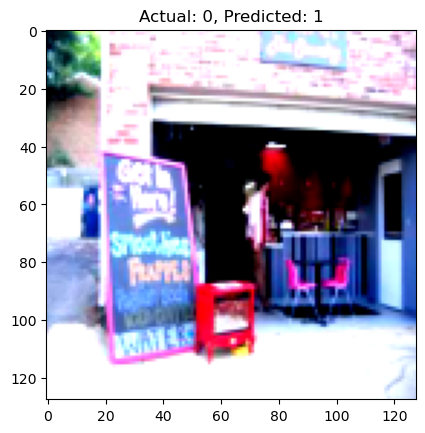

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


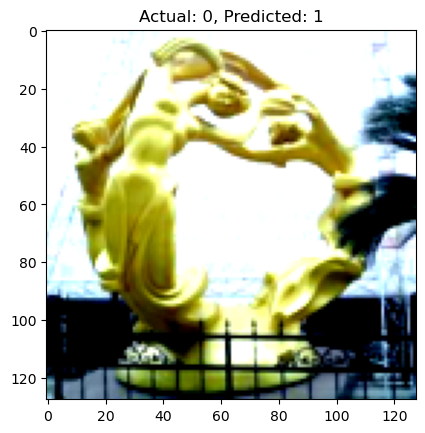

In [41]:
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
import seaborn as sns

def imshow(img, title):
    """Функция для отображения изображения"""
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(title)
    plt.show()

def inference_and_visualize_errors(model, test_loader):
    incorrect_images = []
    incorrect_labels = []
    incorrect_preds = []

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predicted = (outputs > 0.5).float().view(-1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            incorrect_indices = (predicted != labels).nonzero(as_tuple=True)[0]

            for idx in incorrect_indices:
                incorrect_images.append(inputs[idx].cpu())
                incorrect_labels.append(labels[idx].cpu().item())
                incorrect_preds.append(predicted[idx].cpu().item())

    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)

    for i in range(min(10, len(incorrect_images))):
        imshow(incorrect_images[i], f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

        writer.add_image(f'Error_{i}', incorrect_images[i])
        writer.add_text(f'Error_{i}', f'Actual: {int(incorrect_labels[i])}, Predicted: {int(incorrect_preds[i])}')

    return f1, conf_matrix, acc

f1, conf_matrix, acc = inference_and_visualize_errors(model, test_loader)

### Результаты модели

F1-score: 0.9033
Accuracy: 0.9129


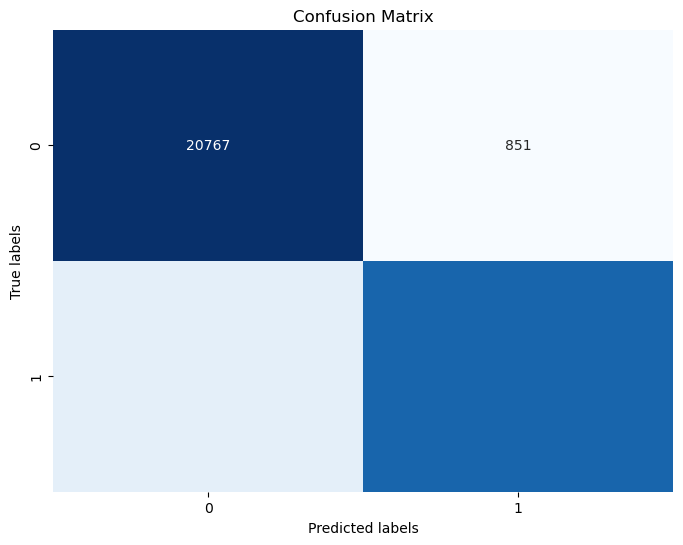

In [42]:
print(f'F1-score: {f1:.4f}')
print(f'Accuracy: {acc:.4f}')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Количество обучаемых параметров

In [43]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Количество обучаемых параметров: {count_parameters(model)}")

Количество обучаемых параметров: 16871489


In [45]:
writer.close()

%load_ext tensorboard

# Путь к логам
log_dir = 'runs/exp_1'

# Запуск TensorBoard
%tensorboard --logdir=runs/exp_1

from IPython.display import IFrame

IFrame(src='http://localhost:6006/', width=1000, height=800)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11872), started 0:00:50 ago. (Use '!kill 11872' to kill it.)

### Выводы

- В данной домашней работе сильно помогло использование батчей, встроенных в pyTorch. Т.к. датасет очень большой, обучение шло очень долго, однако при полной загрузке VRAM удалось достичь результата в ~20 мин/эпоха;
- Для модели используется достаточно классическая реализация, поэтому сложно сказать, что помогло повысить accuracy. Скорее всего, здесь прямая зависимость между тренировочной выборкой и результатами модели;
- При выполнении работы также было полезно использовать чекпоинты для модели, чтобы обучение не происходило сначала;
- Модель перестала обучаться на пятой эпохе, а стала больше подстраиваться под тренировочный датасет;
- Результат можно улучшить, используя аугментацию, однако очень сложно манипулировать с таким большим объемом данных.
- В итоге Accuracy - 0.9129 за 5 эпох (~2 часа обучения).